## Transformers 트랜스포머를 이용한 주가 방향성 예측 모델 만들기

In [2]:
!pip install yfinance

In [3]:
!pip install ta

# TA 라이브러리
# RSI 지표 등 금융 시계열에서 사용하는 지표를 자동으로 계산

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=fdd7752049e104d8e6deda6d25f255c97fc4dbc2ee627d56117d09bd7d9a71db
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [4]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 30.4 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import ta
import koreanize_matplotlib

- 애플(AAPL)의 2013년 - 2023년까지 수집 후 훈련데이터로 사용
- 2024년 1월부터 4월까지 데이터를 테스트 데이터로 사용
- 금융데이터에서 1달 = 20 ~ 21일
- 1년은 252일


In [6]:
train = yf.download('AAPL', start='2013-01-01', end='2023-12-31')
test = yf.download('AAPL', start='2024-01-01', end='2024-04-30')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
train

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.705698,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.494837,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.035379,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,15.941052,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,15.983956,458707200
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868149,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320221,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.419830,48087700


In [8]:
test

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,187.149994,188.440002,183.889999,185.639999,184.938217,82488700
2024-01-03,184.220001,185.880005,183.429993,184.250000,183.553467,58414500
2024-01-04,182.149994,183.089996,180.880005,181.910004,181.222321,71983600
2024-01-05,181.990005,182.759995,180.169998,181.179993,180.495087,62303300
2024-01-08,182.089996,185.600006,181.500000,185.559998,184.858521,59144500
...,...,...,...,...,...,...
2024-04-23,165.350006,167.050003,164.919998,166.899994,166.481216,49537800
2024-04-24,166.539993,169.300003,166.210007,169.020004,168.595917,48251800
2024-04-25,169.529999,170.610001,168.149994,169.889999,169.463730,50558300


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2768 entries, 2013-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2768 non-null   float64
 1   High       2768 non-null   float64
 2   Low        2768 non-null   float64
 3   Close      2768 non-null   float64
 4   Adj Close  2768 non-null   float64
 5   Volume     2768 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 151.4 KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82 entries, 2024-01-02 to 2024-04-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       82 non-null     float64
 1   High       82 non-null     float64
 2   Low        82 non-null     float64
 3   Close      82 non-null     float64
 4   Adj Close  82 non-null     float64
 5   Volume     82 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 4.5 KB


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

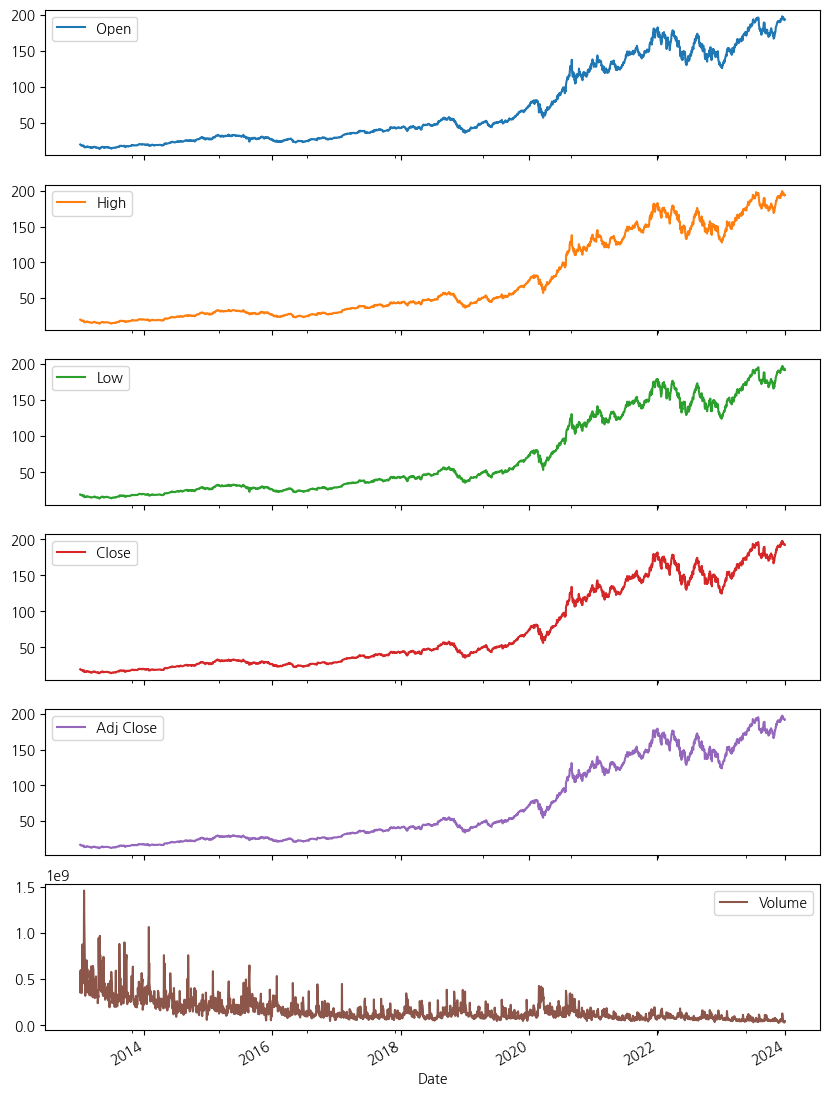

In [11]:
train.plot(figsize=(10,15), subplots=True)

### SMA_14, VMA_14, RSI_14
이 세 가지 지표는 주식의 가격이나 거래량의 흐름을 파악하고, 적절한 매매 시점을 찾는 데 유용하다. <br><br>


1. SMA (Simple Moving Average, 단순 이동 평균)
- 설명: 일정 기간 동안의 주가 평균을 계산한 값이다. 예를 들어, 5일 동안의 주가 평균을 매일 계산해서 그려내면 5일 이동 평균선이 만들어진다.
- 용도: 주가의 전체적인 추세를 파악하는 데 사용된다. 주가가 SMA 위에 있으면 상승 추세, 아래에 있으면 하락 추세로 볼 수 있다.
예시: 20일 SMA는 20일 동안의 주가 평균을 나타내며, 주가가 이 선을 기준으로 어떻게 움직이는지 확인할 수 있다.

2. VMA (Volume Moving Average, 거래량 이동 평균)
- 설명: 일정 기간 동안의 거래량 평균을 나타내는 지표다. SMA가 주가의 평균을 계산한다면, VMA는 거래량의 평균을 계산하는 것이다.
- 용도: 주식 거래의 활발함이나 유동성을 파악하는 데 도움을 준다. 거래량이 평균보다 높으면 주가에 관심이 많다는 신호로 볼 수 있다.
예시: 20일 VMA는 20일 동안의 평균 거래량을 보여준다. 거래량이 급증하거나 감소하는지를 파악하는 데 유용하다.

3. RSI (Relative Strength Index, 상대 강도 지수)
- 설명: 주식이 과매수(너무 많이 사들여져 있는 상태) 또는 과매도(너무 많이 팔려진 상태)인지 판단하는 지표다. 0에서 100 사이의 값으로 표시되며, 70 이상이면 과매수, 30 이하이면 과매도라고 본다.
- 용도: 주식이 과도하게 매수되었는지, 과도하게 매도되었는지 판단해서 매수나 매도 시점을 파악할 때 사용한다.
예시: RSI가 30 미만이면 주가가 너무 많이 떨어졌다고 보고 매수 시점으로 판단할 수 있다. 반대로 70 이상이면 매도 시점으로 볼 수 있다.

In [12]:
train['sma_14'] = train['Close'].rolling(window=14).mean()

In [13]:
test['sma_14'] = test['Close'].rolling(window=14).mean()

In [14]:
train['vma_14'] = train['Volume'].rolling(window=14).mean()
test['vma_14'] = test['Volume'].rolling(window=14).mean()

In [15]:
train['rsi_14'] = ta.momentum.RSIIndicator(train['Close']).rsi()
test['rsi_14'] = ta.momentum.RSIIndicator(test['Close']).rsi()

# 기본값이 14로 맞춰져 있음

In [16]:
train = train.dropna()
test = test.dropna()

In [17]:
train['pct_change'] = train['Close'].pct_change()
test['pct_change'] = test['Close'].pct_change()

<ipython-input-17-e0e405fe5a6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pct_change'] = train['Close'].pct_change()
<ipython-input-17-e0e405fe5a6e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pct_change'] = test['Close'].pct_change()


In [18]:
train['pct_change'].describe()

,pct_change
count,2754.000000
mean,0.001020
std,0.017870
min,-0.128647
25%,-0.007406
50%,0.000889
75%,0.010222
max,0.119808


중위수 (50%)인 0.000889 을 기준으로 하여 target 을 설정한다.

- 50% 이상 : 1
- 50% 이하 : 0

In [19]:
train['target'] = np.where(train['pct_change'] > 0.0008, 1, 0)
test['target'] = np.where(test['pct_change'] > 0.0008, 1, 0)

<ipython-input-19-80d2917f9161>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['target'] = np.where(train['pct_change'] > 0.0008, 1, 0)
<ipython-input-19-80d2917f9161>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['target'] = np.where(test['pct_change'] > 0.0008, 1, 0)


In [20]:
train

,Open,High,Low,Close,Adj Close,Volume,sma_14,vma_14,rsi_14,pct_change,target
Date,,,,,,,,,,,
2013-01-22,18.020000,18.138571,17.736786,18.027500,15.358971,461546400,18.442500,5.357050e+08,34.843050,NaN,0
2013-01-23,18.171785,18.392500,18.027500,18.357500,15.640124,861509600,18.353163,5.572044e+08,42.653035,0.018305,1
2013-01-24,16.428572,16.633215,16.080357,16.089287,13.707662,1460852400,18.119490,6.363392e+08,22.600673,-0.123558,0
2013-01-25,16.131786,16.293928,15.535714,15.710000,13.384520,1208026400,17.897245,6.801744e+08,20.836621,-0.023574,0
2013-01-28,15.636786,16.186071,15.566429,16.065357,13.687279,785517600,17.708291,7.017002e+08,26.615905,0.022620,1
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868149,37122800,195.227859,5.857288e+07,54.609714,-0.005547,0
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320221,28919300,195.201431,5.587937e+07,53.026883,-0.002841,0
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.419830,48087700,195.260716,5.637923e+07,53.291938,0.000518,0


In [21]:
train = train.dropna()
test = test.dropna()

In [22]:
train['target'] = train['target'].shift(-1)
test['target'] = test['target'].shift(-1)

<ipython-input-22-4d646fa3db7e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['target'] = train['target'].shift(-1)
<ipython-input-22-4d646fa3db7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['target'] = test['target'].shift(-1)


In [23]:
train = train.dropna()
test = test.dropna()

In [24]:
train

,Open,High,Low,Close,Adj Close,Volume,sma_14,vma_14,rsi_14,pct_change,target
Date,,,,,,,,,,,
2013-01-23,18.171785,18.392500,18.027500,18.357500,15.640124,861509600,18.353163,5.572044e+08,42.653035,0.018305,0.0
2013-01-24,16.428572,16.633215,16.080357,16.089287,13.707662,1460852400,18.119490,6.363392e+08,22.600673,-0.123558,0.0
2013-01-25,16.131786,16.293928,15.535714,15.710000,13.384520,1208026400,17.897245,6.801744e+08,20.836621,-0.023574,1.0
2013-01-28,15.636786,16.186071,15.566429,16.065357,13.687279,785517600,17.708291,7.017002e+08,26.615905,0.022620,1.0
2013-01-29,16.375000,16.435715,16.147142,16.366785,13.944088,571158000,17.537271,7.097324e+08,31.203836,0.018763,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,196.100006,197.080002,193.500000,194.679993,193.944031,46482500,194.930001,5.902050e+07,57.752982,-0.000770,0.0
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868149,37122800,195.227859,5.857288e+07,54.609714,-0.005547,0.0
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320221,28919300,195.201431,5.587937e+07,53.026883,-0.002841,0.0


In [25]:
X = train.drop(['target'], axis=1)
y = train['target']

In [26]:
X.head()

,Open,High,Low,Close,Adj Close,Volume,sma_14,vma_14,rsi_14,pct_change
Date,,,,,,,,,,
2013-01-23,18.171785,18.392500,18.027500,18.357500,15.640124,861509600,18.353163,557204400.0,42.653035,0.018305
2013-01-24,16.428572,16.633215,16.080357,16.089287,13.707662,1460852400,18.119490,636339200.0,22.600673,-0.123558
2013-01-25,16.131786,16.293928,15.535714,15.710000,13.384520,1208026400,17.897245,680174400.0,20.836621,-0.023574
2013-01-28,15.636786,16.186071,15.566429,16.065357,13.687279,785517600,17.708291,701700200.0,26.615905,0.022620
2013-01-29,16.375000,16.435715,16.147142,16.366785,13.944088,571158000,17.537271,709732400.0,31.203836,0.018763


In [27]:
y

,target
Date,
2013-01-23,0.0
2013-01-24,0.0
2013-01-25,1.0
2013-01-28,1.0
2013-01-29,0.0
...,...
2023-12-21,0.0
2023-12-22,0.0
2023-12-26,0.0


In [28]:
y.value_counts()

,count
target,
1.0,1379
0.0,1374


<Axes: >

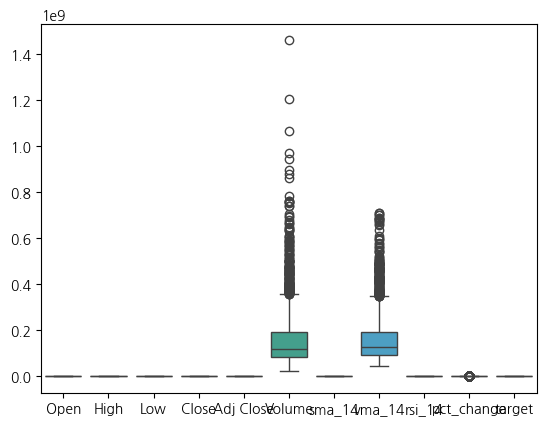

In [29]:
sns.boxplot(train)

In [30]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [31]:
rs = RobustScaler()
mms = MinMaxScaler()
X_rs_scaled = rs.fit_transform(X.copy())
X_mms_scaled = mms.fit_transform(X.copy())

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_rs_scaled, y, shuffle=False, test_size=0.3, random_state=10)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_mms_scaled, y, shuffle=False, test_size=0.3, random_state=10)

## 트랜스포머 모델 정의

In [34]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Dropout, Input, Flatten
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam


In [35]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
  x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
  x = LayerNormalization(epsilon=1e-6)(x)
  res = x + inputs

  # 피드포워드 네트워크
  x = Dense(ff_dim, activation='relu')(res)
  x = Dense(inputs.shape[-1])(x)
  x = LayerNormalization(epsilon = 1e-6)(x)
  return x + res

In [36]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
  inputs = Input(shape=input_shape)
  x = inputs
  for _ in range(num_transformer_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  x = Flatten()(x)
  for dim in mlp_units:
    x = Dense(dim, activation='relu')(x)
    x = Dropout(mlp_dropout)(x)
  outputs = Dense(1, activation='sigmoid')(x)
  return Model(inputs, outputs)


In [37]:
# 모델생성
input_shape = (X_train.shape[1], 1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = build_model(input_shape, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], mlp_dropout=0.4, dropout=0.25)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 10, 1)          │          7,169 │ input_layer[0][0],     │
│ (MultiHeadAttention)      │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 10, 1)          │              2 │ multi_head_attention[… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 10, 1)          │              0 │ layer_normalization[0… │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 10, 4)          │              8 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 10, 1)          │              5 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 10, 1)          │              2 │ dense_1[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 10, 1)          │              0 │ layer_normalization_1… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 10, 1)          │          7,169 │ add_1[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 10, 1)          │              2 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 10, 1)          │              0 │ layer_normalization_2… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 10, 4)          │              8 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 10, 1)          │              5 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 10, 1)          │              2 │ dense_3[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 10, 1)          │              0 │ layer_normalization_3… │
│                      

 Total params: 30,281 (118.29 KB)

 Trainable params: 30,281 (118.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 33s 192ms/step - accuracy: 0.4802 - loss: 0.7050 - val_accuracy: 0.5000 - val_loss: 0.7032
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5151 - loss: 0.6979 - val_accuracy: 0.5024 - val_loss: 0.7022
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5059 - loss: 0.6990 - val_accuracy: 0.5000 - val_loss: 0.7036
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5083 - loss: 0.7030 - val_accuracy: 0.5000 - val_loss: 0.7036
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4634 - loss: 0.7016 - val_accuracy: 0.4976 - val_loss: 0.7038
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5044 - loss: 0.6995 - val_accuracy: 0.5012 - val_loss: 0.7025
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5328 - loss: 0.6931 - val_accuracy: 0.5012 - val_loss: 0.7035
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5048 - loss: 0.6975 - val_accuracy: 0.49

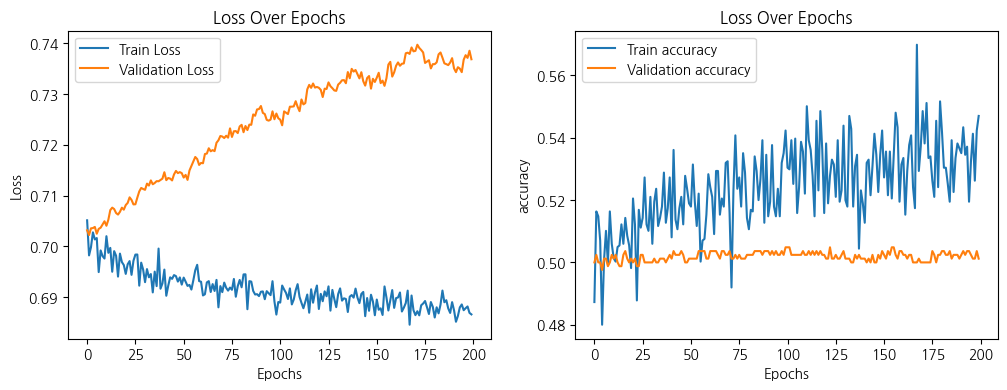

In [38]:
history = model.fit(X_train, y_train, validation_data=[X_test, y_test], epochs=200, batch_size=32)
# RobustScaler 사용한 것

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title("Loss Over Epochs")
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [40]:
# 모델생성
input_shape = (X2_train.shape[1], 1)
X2_train = X2_train.reshape((X2_train.shape[0], X2_train.shape[1], 1))
X2_test = X2_test.reshape((X2_test.shape[0], X2_test.shape[1], 1))

model = build_model(input_shape, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], mlp_dropout=0.4, dropout=0.25)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 10, 1)          │          7,169 │ input_layer_1[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 10, 1)          │              2 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 10, 1)          │              0 │ layer_normalization_8… │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 10, 4)          │              8 │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 10, 1)          │              5 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_9     │ (None, 10, 1)          │              2 │ dense_11[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 10, 1)          │              0 │ layer_normalization_9… │
│                           │                        │                │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 10, 1)          │          7,169 │ add_9[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_10    │ (None, 10, 1)          │              2 │ multi_head_attention_… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 10, 1)          │              0 │ layer_normalization_1… │
│                           │                        │                │ add_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 10, 4)          │              8 │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 10, 1)          │              5 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_11    │ (None, 10, 1)          │              2 │ dense_13[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)         

 Total params: 30,281 (118.29 KB)

 Trainable params: 30,281 (118.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 169ms/step - accuracy: 0.4954 - loss: 0.6939 - val_accuracy: 0.5036 - val_loss: 0.6934
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4896 - loss: 0.6944 - val_accuracy: 0.5036 - val_loss: 0.6932
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4954 - loss: 0.6937 - val_accuracy: 0.5036 - val_loss: 0.6932
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4938 - loss: 0.6951 - val_accuracy: 0.5036 - val_loss: 0.6930
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5264 - loss: 0.6926 - val_accuracy: 0.5012 - val_loss: 0.6930
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4968 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5251 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5024 - loss: 0.6928 - val_accuracy: 0.502

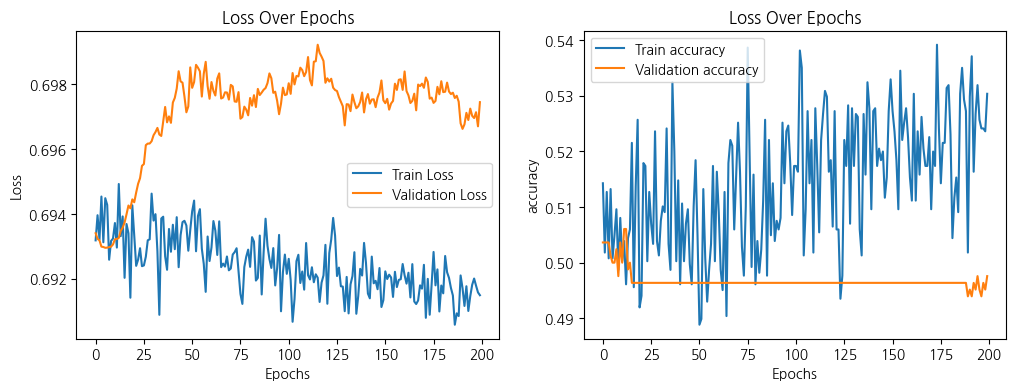

In [41]:
history = model.fit(X2_train, y2_train, validation_data=[X2_test, y2_test], epochs=200, batch_size=32)
# Minmaxscaler 사용한 것

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title("Loss Over Epochs")
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

두개의그래프의 결과물의 차이는

1. RobustScaler() => robustscaler 결과가 더 좋게 나온 것 같음
2. MinMaxScaler()

# RobustScaler 로 한 모델만 확인해보기

### EarlyStopping으로 학습 조기 중단 및 저장하기

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [44]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50)

In [45]:
# ModelCheckpoint : 모델을 중간에 저장하는 옵션

import os
if not os.path.exists("./model"):
    os.makedirs("./model")
    print(f"Directory /model created.")
else:
    print(f"Directory /model already exists.")

Directory /model created.


In [46]:
modelpath = "./model/{epoch:03d}--{val_loss:.4f}.keras"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

In [48]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=[X_test, y_test],
                   callbacks=[early_stopping_callback, checkpointer])

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5054 - loss: 0.7056 - val_accuracy: 0.5048 - val_loss: 0.7089
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5122 - loss: 0.7012 - val_accuracy: 0.5036 - val_loss: 0.7127
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4995 - loss: 0.7043 - val_accuracy: 0.5036 - val_loss: 0.7131
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5095 - loss: 0.7003 - val_accuracy: 0.5024 - val_loss: 0.7146
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5015 - loss: 0.7014 - val_accuracy: 0.5036 - val_loss: 0.7157
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4949 - loss: 0.7032 - val_accuracy: 0.5048 - val_loss: 0.7167
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5149 - loss: 0.6994 - val_accuracy: 0.5036 - val_loss: 0.7172
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5016 - loss: 0.7019 - val_accuracy: 0.5036 - 

### 저장된 베스트 모델을 불러와서 테스트 하기

In [49]:
from tensorflow.keras.models import load_model


In [50]:
best_model = load_model("./model/001--0.7089.keras")

In [52]:
from sklearn.metrics import classification_report

In [53]:
best_pred = best_model.predict(X_test)
best_pred = pd.DataFrame(best_pred)
best_pred = best_pred[0].apply(lambda x: 1 if x > 0.5 else 0)
print(classification_report(y_test, best_pred))

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

         0.0       0.54      0.11      0.19       416
         1.0       0.50      0.90      0.64       410

    accuracy                           0.50       826
   macro avg       0.52      0.51      0.42       826
weighted avg       0.52      0.50      0.41       826

